## Task
Train an MLP model on a toy dataset (at least 3 layers). Make a random pruning of the models. Visualize the binary matrix projection onto 2d-space with color corresponding to accuracy.

#Experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Progress bar
from tqdm.auto import tqdm

## PyTorch Data Loading
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

# Projections
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
## JAX
import jax
import jax.numpy as jnp
from jax import random, vmap, custom_jvp, grad

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install -q flax
    import flax
from flax import linen as nn
from flax.training import train_state

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## Data

We will use MNIST dataset

In [3]:
train_data = torchvision.datasets.MNIST(root='mnist', train=True, download=True)
test_data = torchvision.datasets.MNIST(root='mnist', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 130190581.48it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 100112143.66it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 58013382.85it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1871735.98it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [4]:
def numpy_collate(batch):
    batch_x = []
    batch_y = []
    for x, y in batch:
      batch_x.append(np.array(x))
      batch_y.append(y)
    return np.array(batch_x), np.array(batch_y, dtype=int)

BATCH_SIZE = 64
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, collate_fn=numpy_collate)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=numpy_collate)

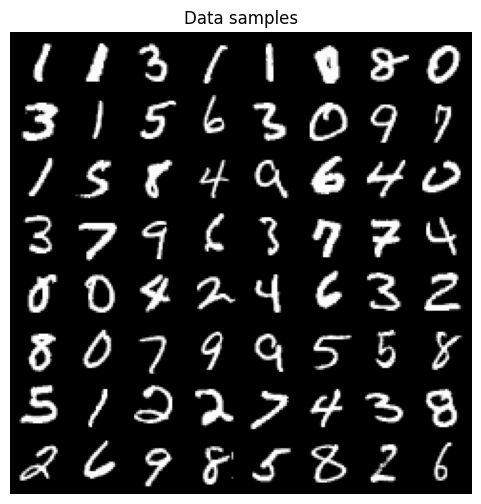

In [5]:
train_sample = next(iter(train_loader))
grid_samples = make_grid(torch.from_numpy(train_sample[0]).unsqueeze(1), nrow=8)
grid_img = grid_samples.permute(1, 2, 0)
figsize = (6, 6)
plt.figure(figsize=figsize)
plt.title('Data samples')
plt.imshow(grid_img)
plt.axis('off')
plt.show()

## Training

Define MLP model and Trainer

In [6]:
class SimpleMLP(nn.Module):
    @nn.compact
    def __call__(self, x):
      x = x.reshape(len(x), -1)
      x = nn.Dense(features=256)(x)
      x = nn.relu(x)
      x = nn.Dense(features=128)(x)
      x = nn.relu(x)
      x = nn.Dense(features=64)(x)
      x = nn.relu(x)

      x = nn.Dense(features=10)(x)
      return x

In [7]:
def cross_entropy(model, params, batch_x, batch_y):
    logits = model.apply({'params': params}, batch_x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, batch_y).mean()

class TrainerModule:
    def __init__(self, lr, n_epochs, seed=42):
        super().__init__()
        self.seed = seed
        self.lr = lr
        self.n_epochs = n_epochs

        # Create empty model. Note: no parameters yet
        self.model = SimpleMLP()
        # Create jitted training function
        self.create_functions()
        # Initialize model
        self.init_model()

    def create_functions(self):
        # Training function
        def train_step(state, batch_x, batch_y):
            loss_fn = lambda params: cross_entropy(self.model, params, batch_x, batch_y)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            #optimizer step
            state = state.apply_gradients(grads=grads)
            return state, loss
        self.train_step = jax.jit(train_step)

    def init_model(self):
        # Initialize model
        rng = jax.random.PRNGKey(self.seed)
        key1, key2 = random.split(rng)
        dummy_input = random.normal(key1, (64, 28, 28))
        params = self.model.init(key2, dummy_input)['params']
        # Initialize optimizer
        optimizer = optax.adam(self.lr)
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, visualize=False):
        # Train model for defined number of epochs
        losses = []
        for epoch_idx in range(1, self.n_epochs+1):
            loss = self.train_epoch(epoch=epoch_idx)
            losses.append(loss)

        if visualize:
          plt.figure(figsize=(5, 4))
          plt.plot(losses)
          plt.xlabel('epoch')
          plt.title('Training loss')
          plt.show()

    def train_epoch(self, epoch):
        # Train model for one epoch, and avg loss
        losses = []
        for batch_x, batch_y in train_loader:
            self.state, loss = self.train_step(self.state, batch_x, batch_y)
            losses.append(loss)
        avg_loss = np.mean(jax.device_get(losses))
        return avg_loss

    def score_model(self):
        # Estimate accuracy
        correct = 0.
        for batch_x, batch_y in test_loader:
            logits = self.model.apply({'params': self.state.params}, batch_x)
            correct += np.sum(batch_y == np.argmax(logits, -1))
        accuracy = correct / len(test_data)
        return jax.device_get(accuracy)

Train initial model

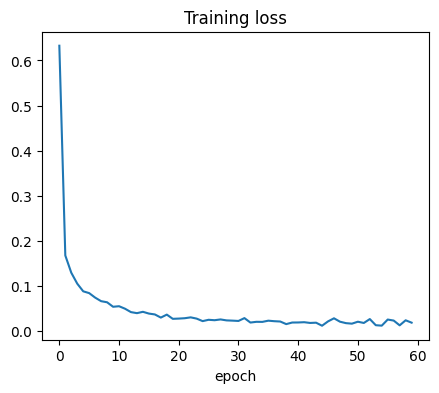

In [8]:
trainer = TrainerModule(lr=1e-3, n_epochs=60)
trainer.train_model(visualize=True)

In [9]:
score = trainer.score_model()

In [10]:
print('Accuracy before pruning is', np.round(score, 3))

Accuracy before pruning is 0.981


## Pruning

Next we randomly prune the pretrained model, calculate accuracy and save corresponding binary matrices 

In [11]:
def get_MLP_accuracy(params):
  """
  Accuracy of MLP model with weights specified by params on test set
  """
  model = SimpleMLP()
  correct = 0.
  for batch_x, batch_y in test_loader:
      logits = model.apply({'params': params}, batch_x)
      correct += np.sum(batch_y == np.argmax(logits, -1))
  accuracy = correct / len(test_data)

  return jax.device_get(accuracy)

In [12]:
#total number of weights
num_kernel_params = 0
num_bias_params = 0
for param, weight in trainer.state.params.items():
  num_kernel_params += np.prod(weight['kernel'].shape) 
  num_bias_params += len(weight['bias'])

In [13]:
binary_matrices = []
n_iters = 10 # number of iterations with fixed prune rate
prune_rates = []
accuracy_scores = []

for prune_bias in [True, False]: # whether to prune bias weights or not
  for prune_rate in tqdm([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    for iter in range(n_iters):
      prune_rates.append(prune_rate)

      if prune_bias:
        num_params = num_kernel_params + num_bias_params
      else:
        num_params = num_kernel_params

      # Generate random binary matrix
      binary_mask = np.ones(num_params)
      prune_idx = np.random.choice(np.arange(num_params), size=int(num_params*prune_rate), replace=False)
      binary_mask[prune_idx] = 0
      binary_matrices.append(binary_mask)

      #Prune parameters according to binary matrix
      pruned_params = {}
      start_of_block = 0
      for param, weight in trainer.state.params.items():
        if prune_bias:
          end_of_block = start_of_block + len(weight['bias'])
          bias_mask = binary_mask[start_of_block:end_of_block]
          start_of_block = end_of_block
        else:
          bias_mask = np.ones(weight['bias'].shape)
        
        end_of_block = start_of_block + np.prod(weight['kernel'].shape)
        kernel_mask = binary_mask[start_of_block:end_of_block].reshape(weight['kernel'].shape)
        start_of_block = end_of_block

        pruned_layer = {'bias' : weight['bias'] * bias_mask, 'kernel' : weight['kernel'] * kernel_mask}
        pruned_params[param] = pruned_layer
      
      #Compute and store accuracy
      accuracy_scores.append(np.round(get_MLP_accuracy(pruned_params), 3))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

## Visualization

In [28]:
first_half = int(len(binary_matrices)*0.5) # with bias pruning

pca = PCA(100)
tsne = TSNE()
pca_projections = pca.fit_transform(np.stack(binary_matrices[:first_half]))
tsne_projections = tsne.fit_transform(pca_projections)

pca = PCA(2)
pca_projections = pca.fit_transform(np.stack(binary_matrices[:first_half]))

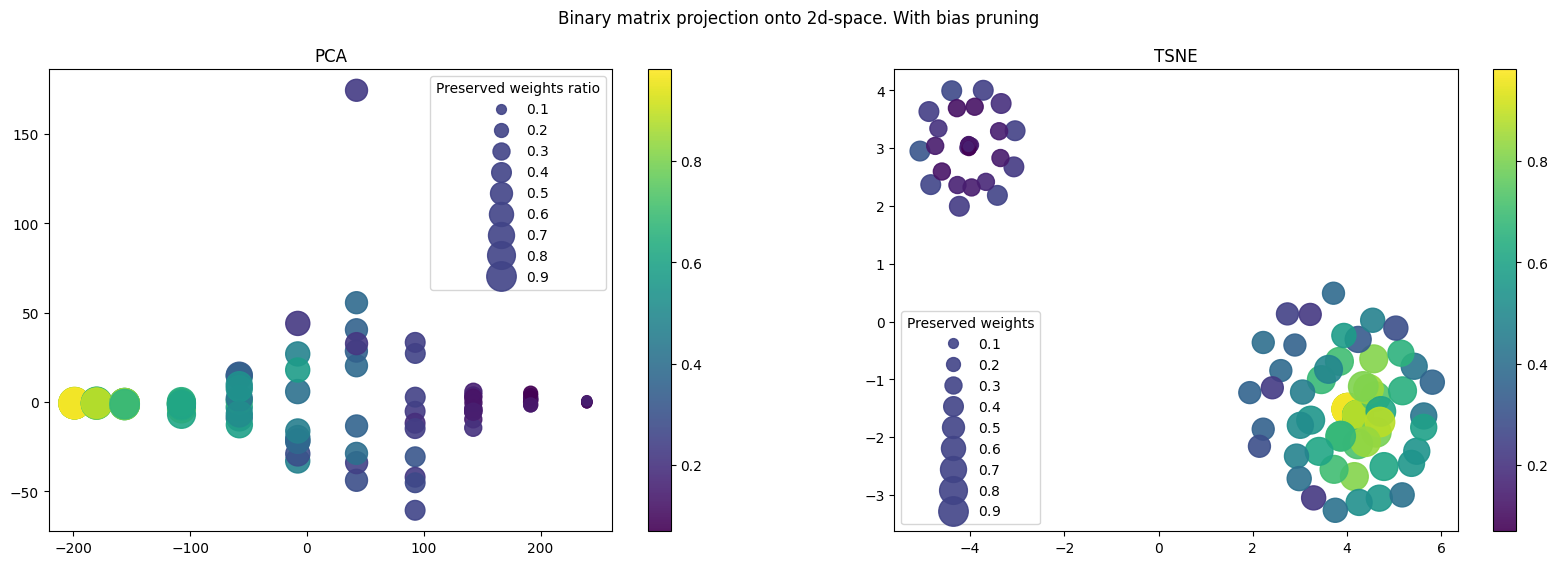

In [39]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sc = plt.scatter(pca_projections[:, 0], 
                pca_projections[:, 1], 
                c = accuracy_scores[:first_half],
                s = (1 - np.array(prune_rates[:first_half]))*500,
                alpha=0.9)
plt.colorbar()

kw = dict(prop="sizes", num=7, color=sc.cmap(0.2),
          func=lambda s: s/500)
plt.legend(*sc.legend_elements(**kw), title="Preserved weights ratio")
plt.title('PCA')

plt.subplot(1, 2, 2)
sc = plt.scatter(tsne_projections[:, 0], 
                tsne_projections[:, 1], 
                c = accuracy_scores[:first_half],
                s = (1 - np.array(prune_rates[:first_half]))*500,
                alpha=0.9)
plt.colorbar()

kw = dict(prop="sizes", num=7, color=sc.cmap(0.2),
          func=lambda s: s/500)
plt.legend(*sc.legend_elements(**kw), title="Preserved weights", loc='lower left')
plt.title('TSNE')


plt.suptitle('Binary matrix projection onto 2d-space. With bias pruning')
plt.show()

In [40]:
pca = PCA(100)
tsne = TSNE()
pca_projections = pca.fit_transform(np.stack(binary_matrices[first_half:]))
tsne_projections = tsne.fit_transform(pca_projections)

pca = PCA(2)
pca_projections = pca.fit_transform(np.stack(binary_matrices[first_half:]))

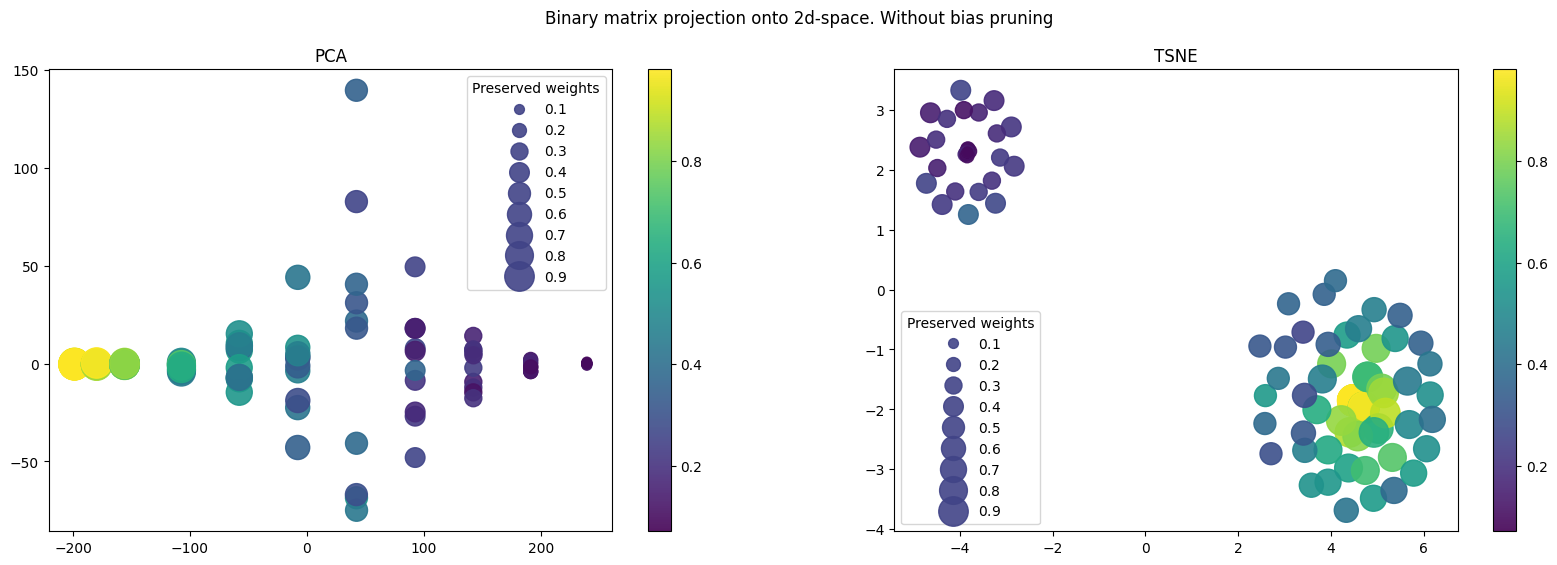

In [47]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sc = plt.scatter(pca_projections[:, 0], 
                pca_projections[:, 1], 
                c = accuracy_scores[first_half:],
                s = (1 - np.array(prune_rates[first_half:]))*500,
                alpha=0.9)
plt.colorbar()

kw = dict(prop="sizes", num=7, color=sc.cmap(0.2), func=lambda s: s/500)
plt.legend(*sc.legend_elements(**kw), title="Preserved weights")
plt.title('PCA')

plt.subplot(1, 2, 2)
sc = plt.scatter(tsne_projections[:, 0], 
                tsne_projections[:, 1], 
                c = accuracy_scores[first_half:],
                s = (1 - np.array(prune_rates[first_half:]))*500,
                alpha=0.9)
plt.colorbar()

kw = dict(prop="sizes", color=sc.cmap(0.2), func=lambda s: s/500)
plt.legend(*sc.legend_elements(**kw), title="Preserved weights", loc='lower left')
plt.title('TSNE')


plt.suptitle('Binary matrix projection onto 2d-space. Without bias pruning')
plt.show()

Results

1. Prune rate is the main factor that affects accuracy
2. We can see that the projections of binary matrices are also positioned with respect to the number of pruned weights
3. Thus, pruned models with high accuracy are separated from those with low accuracy


Now, let's fix prune rate

## Experiment with fixed prune rate

In [ ]:
binary_matrices = []
n_iters = 100
accuracy_scores = []

prune_bias = True
prune_rate = 0.1
for iter in range(n_iters):
  if prune_bias:
    num_params = num_kernel_params + num_bias_params
  else:
    num_params = num_kernel_params

  # Generate random binary matrix
  binary_mask = np.ones(num_params)
  prune_idx = np.random.choice(np.arange(num_params), size=int(num_params*prune_rate), replace=False)
  binary_mask[prune_idx] = 0
  binary_matrices.append(binary_mask)

  #Prune parameters according to binary matrix
  pruned_params = {}
  start_of_block = 0
  for param, weight in trainer.state.params.items():
    if prune_bias:
      end_of_block = start_of_block + len(weight['bias'])
      bias_mask = binary_mask[start_of_block:end_of_block]
      start_of_block = end_of_block
    else:
      bias_mask = np.ones(weight['bias'].shape)
    
    end_of_block = start_of_block + np.prod(weight['kernel'].shape)
    kernel_mask = binary_mask[start_of_block:end_of_block].reshape(weight['kernel'].shape)
    start_of_block = end_of_block

    pruned_layer = {'bias' : weight['bias'] * bias_mask, 'kernel' : weight['kernel'] * kernel_mask}
    pruned_params[param] = pruned_layer
  
  #Compute and store accuracy
  accuracy_scores.append(np.round(get_MLP_accuracy(pruned_params), 4))

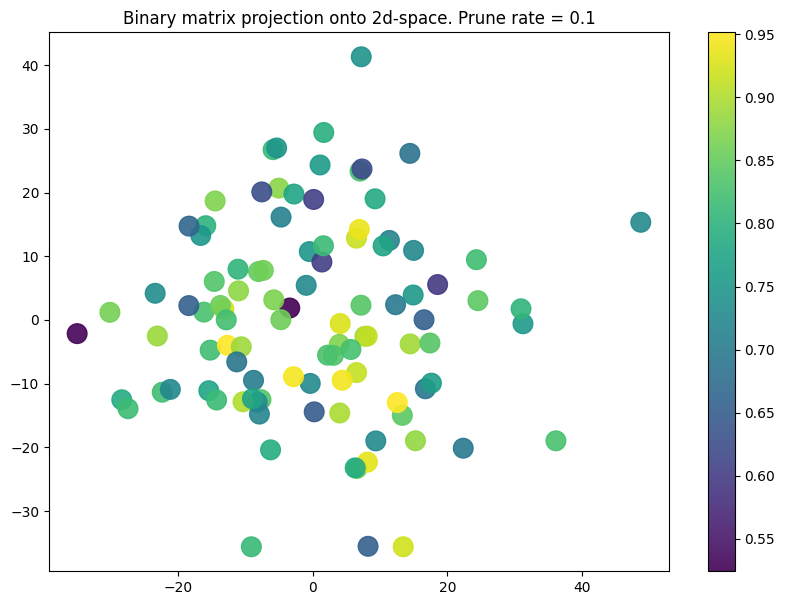

In [ ]:
pca = PCA(2)
pca_projections = pca.fit_transform(np.stack(binary_matrices))

plt.figure(figsize=(10, 7))
sc = plt.scatter(pca_projections[:,0], 
                pca_projections[:, 1], 
                c = accuracy_scores,
                s = 200,
                alpha=0.9)
plt.colorbar()
plt.title('Binary matrix projection onto 2d-space. Prune rate = 0.1')
plt.show()

Results

1. With constant prune rate, the projections become less separated, and we do not have evident clusters

2. However, we can see that the color assignment is not completely random. Some areas have more "high-accuracy" projections while others are filled with "low-accuracy" ones
